In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

from utils import RWTH_COLORS

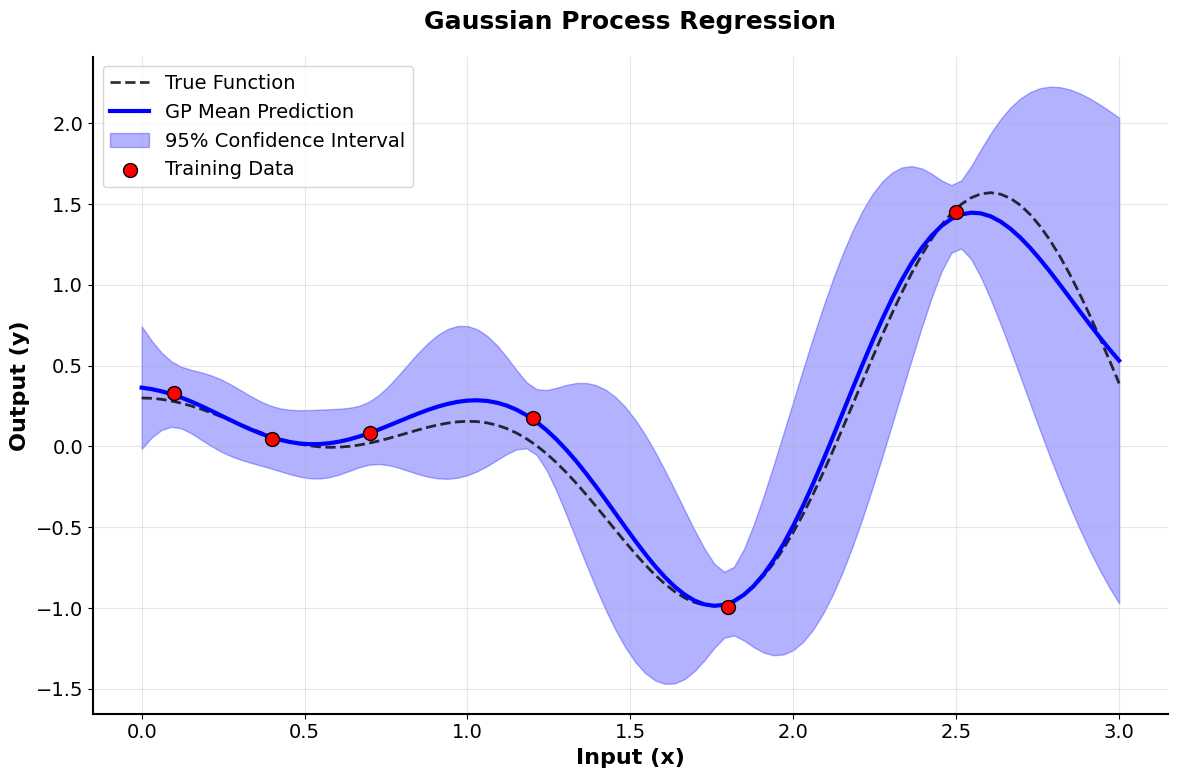

In [2]:
# Chart 1: Gaussian Process Concept Visualization

# Define a simple 1D function to approximate
def true_function(x):
    return 0.5 * x * np.sin(3 * x) + 0.3 * np.cos(5 * x)

# Generate training data
np.random.seed(42)
X_train = np.array([0.1, 0.4, 0.7, 1.2, 1.8, 2.5]).reshape(-1, 1)
y_train = true_function(X_train.ravel()) + np.random.normal(0, 0.1, X_train.shape[0])

# Create test points for prediction
X_test = np.linspace(0, 3, 100).reshape(-1, 1)
y_true = true_function(X_test.ravel())

# Fit Gaussian Process
kernel = C(1.0) * RBF(1.0)
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.1**2, n_restarts_optimizer=10)
gp.fit(X_train, y_train)

# Make predictions
y_pred, sigma = gp.predict(X_test, return_std=True)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot true function
ax.plot(X_test.ravel(), y_true, 'k--', linewidth=2, label='True Function', alpha=0.8)

# Plot GP mean prediction
ax.plot(X_test.ravel(), y_pred, 'b-', linewidth=3, label='GP Mean Prediction')

# Plot confidence intervals
ax.fill_between(X_test.ravel(), y_pred - 2*sigma, y_pred + 2*sigma, 
                alpha=0.3, color='blue', label='95% Confidence Interval')

# Plot training points
ax.scatter(X_train.ravel(), y_train, c='red', s=100, zorder=5, 
          label='Training Data', edgecolor='black', linewidth=1)

# Formatting
ax.set_xlabel('Input (x)', fontsize=16, fontweight='bold')
ax.set_ylabel('Output (y)', fontsize=16, fontweight='bold')
ax.set_title('Gaussian Process Regression', 
             fontsize=18, fontweight='bold', pad=20)
ax.legend(fontsize=14, loc='upper left')
ax.grid(True, alpha=0.3)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('/Users/julian/Library/CloudStorage/OneDrive-StudentsRWTHAachenUniversity/03 Research/02 BA/figures/toy_charts/GP_concept_clean.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

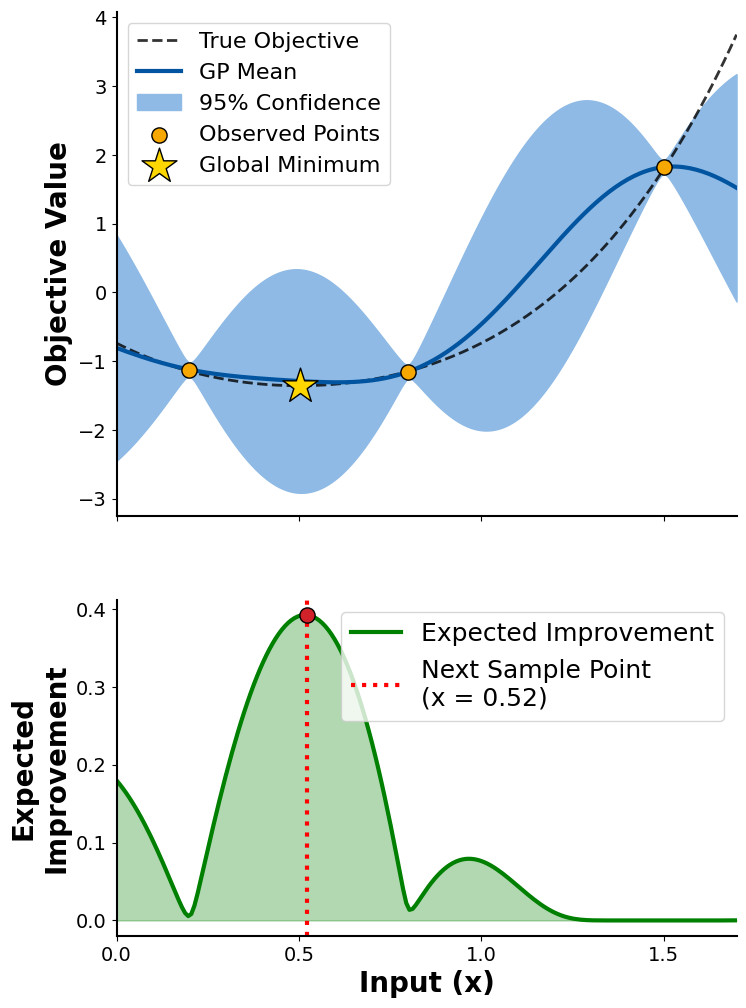

In [3]:
# Chart 2: Bayesian Optimization Concept Visualization

# Define an objective function to optimize (with a global minimum)
def objective_function(x):
    return -(-0.9*(1.4 - 3*x + 4*x**2 - 2*x**3 + x**4) + 2)

# Expected Improvement acquisition function
def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)
    
    mu_sample_opt = np.min(mu_sample)  # <-- for minimization
    
    with np.errstate(divide='warn'):
        imp = mu_sample_opt - mu - xi  # <-- for minimization
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    
    return ei

# Initial sampling points
np.random.seed(42)
X_init = np.array([0.2, 0.8, 1.5]).reshape(-1, 1)
y_init = objective_function(X_init.ravel()) + np.random.normal(0, 0.05, X_init.shape[0])

# Test points
X_plot = np.linspace(0, 1.7, 200).reshape(-1, 1)
y_true_obj = objective_function(X_plot.ravel())

# Fit GP to initial data
kernel_bo = C(1.0) * RBF(0.5)
gp_bo = GaussianProcessRegressor(kernel=kernel_bo, alpha=0.05**2, n_restarts_optimizer=10)
gp_bo.fit(X_init, y_init)

# Predict with GP
y_pred_bo, sigma_bo = gp_bo.predict(X_plot, return_std=True)

# Calculate Expected Improvement
ei = expected_improvement(X_plot, X_init, y_init, gp_bo)

# Find next sampling point (maximum EI)
next_x = X_plot[np.argmax(ei)]

# Create the plot with custom height ratios
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12), sharex=True, 
                               height_ratios=[3, 2], gridspec_kw={'hspace': 0.2})

# Top subplot: Objective function and GP
# Plot true objective
ax1.plot(X_plot.ravel(), y_true_obj, 'k--', linewidth=2, label='True Objective', alpha=0.8)

# Plot GP mean and uncertainty
ax1.plot(X_plot.ravel(), y_pred_bo, 'b-', linewidth=3, label='GP Mean', color='#01549F')
ax1.fill_between(X_plot.ravel(), y_pred_bo - 2*sigma_bo, y_pred_bo + 2*sigma_bo, 
                alpha=1, color='#8EBAE5', label='95% Confidence')

# Plot sampled points
ax1.scatter(X_init.ravel(), y_init, c=RWTH_COLORS['orange'][0], s=120, zorder=5, 
           label='Observed Points', edgecolor='black', linewidth=1)

# Highlight global optimum
opt_idx = np.argmin(y_true_obj)
ax1.scatter(X_plot[opt_idx], y_true_obj[opt_idx], c='gold', s=700, 
           marker='*', zorder=6, label='Global Minimum', edgecolor='black', linewidth=1)

# Formatting top subplot
ax1.set_ylabel('Objective Value', fontsize=20, fontweight='bold')
#ax1.set_title('Bayesian Optimization', fontsize=18, fontweight='bold', pad=20)
ax1.legend(fontsize=16, loc='upper left')
ax1.grid(True, alpha=0.0)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
# Set x-axis ticks with 0.5 step size
ax1.set_xticks(np.arange(0, 1.8, 0.5))
ax1.set_xlim(0, 1.7)

# Bottom subplot: Acquisition function
ax2.plot(X_plot.ravel(), ei.ravel(), 'g-', linewidth=3, label='Expected Improvement')
ax2.fill_between(X_plot.ravel(), 0, ei.ravel(), alpha=0.3, color='green')

# Highlight next sampling point
ax2.axvline(next_x, color='red', linestyle=':', linewidth=3, 
           label=f'Next Sample Point\n(x = {next_x[0]:.2f})')
ax2.scatter(next_x, np.max(ei), c='#D1222A', s=120, zorder=5, 
           edgecolor='black', linewidth=1)

# Formatting bottom subplot
ax2.set_xlabel('Input (x)', fontsize=20, fontweight='bold')
ax2.set_ylabel('Expected\nImprovement', fontsize=20, fontweight='bold')
ax2.legend(fontsize=18, loc='upper right')
ax2.grid(False, alpha=0.0)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
# Set x-axis ticks with 0.5 step size
ax2.set_xticks(np.arange(0, 1.8, 0.5))

plt.tight_layout()
plt.savefig('/Users/julian/Library/CloudStorage/OneDrive-StudentsRWTHAachenUniversity/03 Research/02 BA/figures/toy_charts/BO_concept_clean.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

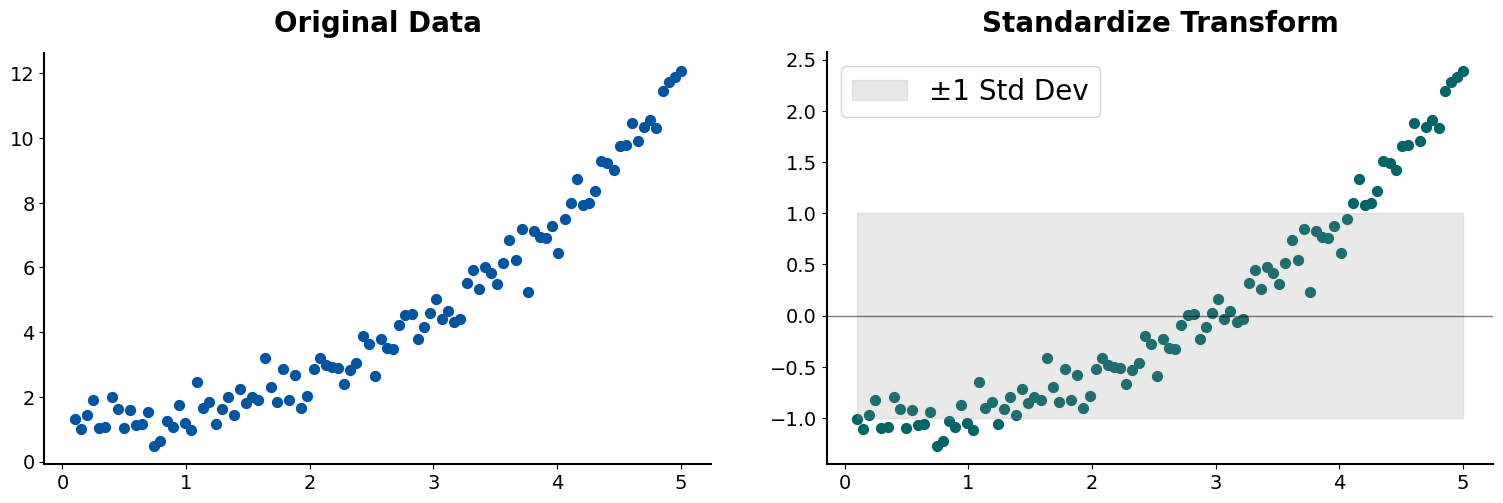

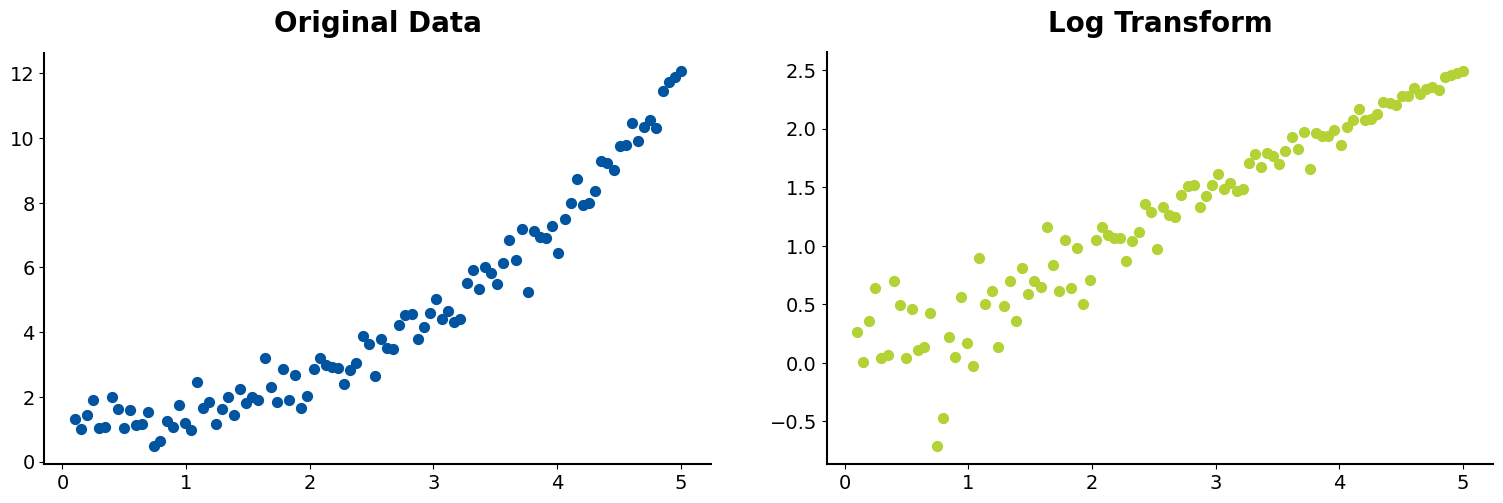

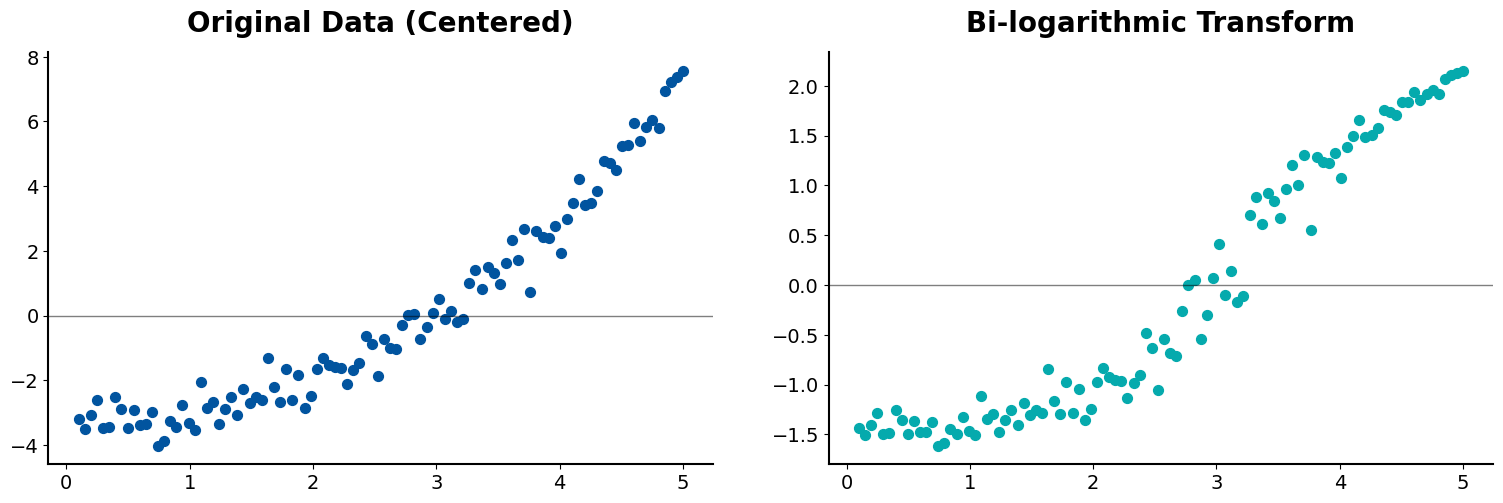

Transformation Statistics:
Original data - Mean: 4.512, Std: 3.166
Standardized - Mean: 0.000, Std: 1.000
Log transform - Mean: 1.233, Std: 0.775
Bilog transform - Mean: -0.132, Std: 1.278


In [4]:
# Chart 3: Data Transformation Comparison

# Generate sample data with different characteristics
np.random.seed(42)
n_samples = 100

# Create sample data with exponential-like distribution (suitable for log transform)
x_data = np.linspace(0.1, 5, n_samples)
y_original = np.exp(0.5 * x_data) + np.random.normal(0, 0.5, n_samples)
y_original = np.maximum(y_original, 0.1)  # Ensure positive values for log transform

# Define transformation functions
def standardize_transform(data):
    """Standardize data to have mean=0 and std=1"""
    return (data - np.mean(data)) / np.std(data)

def log_transform(data):
    """Apply log transformation (log base 10)"""
    return np.log(np.maximum(data, 1e-10))  # Avoid log(0)

def bilog_transform(data):
    """Apply bi-logarithmic transformation: sign(y) * log1p(abs(y))"""
    return np.sign(data) * np.log1p(np.abs(data))

# Apply transformations
y_standardized = standardize_transform(y_original)
y_log = log_transform(y_original)

# For bilog, create data with both positive and negative values
y_bilog_data = y_original - np.mean(y_original)  # Center around 0
y_bilog = bilog_transform(y_bilog_data)

# Chart 3a: Original vs Standardized
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Original data
ax1.scatter(x_data, y_original, c='#01549F', s=50, alpha=1)
#ax1.plot(x_data, np.exp(0.5 * x_data), 'k--', linewidth=2, alpha=0.8, label='True Function')
ax1.set_title('Original Data', fontsize=20, fontweight='bold', pad=15)
#ax1.set_xlabel('Input (x)', fontsize=20, fontweight='bold')
#ax1.set_ylabel('Output (y)', fontsize=20, fontweight='bold')
ax1.grid(True, alpha=0.0)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Standardized data
ax2.scatter(x_data, y_standardized, c='#016567', s=50, alpha=1)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
# Fill the ±1 sigma area with light grey
ax2.fill_between(x_data, -1, 1, alpha=0.2, color='#939598', label='±1 Std Dev')
ax2.set_title('Standardize Transform', fontsize=20, fontweight='bold', pad=15)
#ax2.set_xlabel('Input (x)', fontsize=20, fontweight='bold')
#ax2.set_ylabel('Standardized Output', fontsize=20, fontweight='bold')
ax2.legend(fontsize=20)
ax2.grid(True, alpha=0.0)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout(pad=3.0)
plt.savefig('/Users/julian/Library/CloudStorage/OneDrive-StudentsRWTHAachenUniversity/03 Research/02 BA/figures/toy_charts/standardization_comparison_clean.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Chart 3b: Original vs Log Transform
fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(16, 6))

# Original data
ax3.scatter(x_data, y_original, c='#01549F', s=50, alpha=1)
#ax3.plot(x_data, np.exp(0.5 * x_data), 'k--', linewidth=2, alpha=0.8, label='True Function')
ax3.set_title('Original Data', fontsize=20, fontweight='bold', pad=15)
#ax3.set_xlabel('Input (x)', fontsize=20, fontweight='bold')
#ax3.set_ylabel('Output (y)', fontsize=20, fontweight='bold')
ax3.grid(True, alpha=0.0)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

# Log transformed data
ax4.scatter(x_data, y_log, c='#B3D235', s=50, alpha=1)
#log_trend = 0.5 * x_data  # Expected log trend
#ax4.plot(x_data, log_trend, 'k--', linewidth=2, alpha=0.8, label='Expected Trend')
ax4.set_title('Log Transform', fontsize=20, fontweight='bold', pad=15)
#ax4.set_xlabel('Input (x)', fontsize=20, fontweight='bold')
#ax4.set_ylabel('log(Output)', fontsize=20, fontweight='bold')
ax4.grid(True, alpha=0.0)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

plt.tight_layout(pad=3.0)
plt.savefig('/Users/julian/Library/CloudStorage/OneDrive-StudentsRWTHAachenUniversity/03 Research/02 BA/figures/toy_charts/log_transform_comparison_clean.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Chart 3c: Original vs Bilog Transform
fig3, (ax5, ax6) = plt.subplots(1, 2, figsize=(16, 6))

# Original data (centered for bilog comparison)
ax5.scatter(x_data, y_bilog_data, c='#01549F', s=50, alpha=1)
ax5.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
ax5.set_title('Original Data (Centered)', fontsize=20, fontweight='bold', pad=15)
#ax5.set_xlabel('Input (x)', fontsize=20, fontweight='bold')
#ax5.set_ylabel('Centered Output (y)', fontsize=20, fontweight='bold')
ax5.grid(True, alpha=0.0)
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)

# Bilog transformed data
ax6.scatter(x_data, y_bilog, c='#05AAAD', s=50, alpha=1)
ax6.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
ax6.set_title('Bi-logarithmic Transform', fontsize=20, fontweight='bold', pad=15)
#ax6.set_xlabel('Input (x)', fontsize=20, fontweight='bold')
#ax6.set_ylabel('Bilog(Output)', fontsize=20, fontweight='bold')
ax6.grid(True, alpha=0.0)
ax6.spines['top'].set_visible(False)
ax6.spines['right'].set_visible(False)

plt.tight_layout(pad=3.0)
plt.savefig('/Users/julian/Library/CloudStorage/OneDrive-StudentsRWTHAachenUniversity/03 Research/02 BA/figures/toy_charts/bilog_transform_comparison_clean.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Transformation Statistics:")
print(f"Original data - Mean: {np.mean(y_original):.3f}, Std: {np.std(y_original):.3f}")
print(f"Standardized - Mean: {np.mean(y_standardized):.3f}, Std: {np.std(y_standardized):.3f}")
print(f"Log transform - Mean: {np.mean(y_log):.3f}, Std: {np.std(y_log):.3f}")
print(f"Bilog transform - Mean: {np.mean(y_bilog):.3f}, Std: {np.std(y_bilog):.3f}")